In this notebook, we inspect **in which way a tabular dataset as Census can be used by an AI based on graphs to estimate wealthiness of individuals**. 

Therefore, we proceed in 2 steps:

**1. We prepare data to be handled by a model based on a graph**
We transform them into a graph, that involves strong assumptions on the features involved in connections...

**2. We train an AI based on graphs**
Here, we begin with a Graphical Neural Network (GNN) based on a Multi-Layer Perceptron (MLP), requiring the library Torch.

**3. We inspect if the graph-based AI indeed reflects common & expert knowledge on**
In particular, regarding the non-sense of certain inferences that should absolutely be avoided (e.g. education may influence occupation, but not the reverse).

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# Data preparation for binary classification with graphs (Census)
For this reshaping (and also interpretation, see below the choice of edges) of data tables to graphs, we based on https://colab.research.google.com/drive/1_eR7DXBF3V4EwH946dDPOxeclDBeKNMD?usp=sharing#scrollTo=WuggdIItffpv.

## General preparation - handle categorical features
Here, we handle the categorical features through label-encoding. 

In [2]:
import sys
sys.path.append("../")

import time
from sklearn import datasets

from sklearn.preprocessing import LabelEncoder

import torch
from torch_geometric.data import Data

import tensorflow as tf

import itertools
import numpy as np
import pandas as pd

from classif_basic.data_preparation import train_valid_test_split, set_target_if_feature, automatic_preprocessing

from classif_basic.graph import table_to_graph, add_new_edge

2023-02-11 22:40:02.120180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 22:40:03.819314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-11 22:40:03.819404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-11 22:40:03.819415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Prepare data

Fix precise % of population distribution (sex: Male, Female) and % of wealthiness according to sex. In that way, we could inspect if the structure of the model (here based on a graph) integrates this "sexist" representation of the world. 

In [3]:
# preparing the dataset on clients for binary classification
from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=1590, as_frame=True)

t0 = time.time()

X = data.data
Y = (data.target == '>50K') * 1

In [4]:
dataset = X.copy()
dataset['target'] = Y
dataset

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,0
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,1
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,0
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,0


In [5]:
# here, "treatment" is saw as being 'Male' and not 'Female'

df_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==1)]
df_no_response_if_feature=dataset.loc[(dataset['sex']=='Male')&(dataset['target']==0)]
df_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==1)]
df_no_response_if_not_feature=dataset.loc[(dataset['sex']=='Female')&(dataset['target']==0)]

print(df_response_if_feature.shape[0])
print(df_no_response_if_feature.shape[0])
print(df_response_if_not_feature.shape[0])
print(df_no_response_if_not_feature.shape[0])


# % of men selected by the initial data
df_response_if_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_feature.shape[0])

9918
22732
1769
14423


0.3037672281776417

In [6]:
# % of women selected by the initial data
df_response_if_not_feature.shape[0]/(df_response_if_feature.shape[0]+df_no_response_if_not_feature.shape[0])

0.07267573230352081

In [7]:
len_dataset = 20_000

percentage_feature= 70
percentage_response_if_feature=70
percentage_response_if_not_feature=10

sexist_dataset = set_target_if_feature(
    df_response_if_feature=df_response_if_feature,
    df_no_response_if_feature=df_no_response_if_feature,
    df_response_if_not_feature=df_response_if_not_feature,
    df_no_response_if_not_feature=df_no_response_if_not_feature,
    len_dataset=len_dataset,
    percentage_feature=percentage_feature,
    percentage_response_if_feature=percentage_response_if_feature,
    percentage_response_if_not_feature=percentage_response_if_not_feature)

len_dataset: 20000
nb indivs feature with response: 9800
nb indivs feature with no response: 4200
nb indivs not_feature with response: 600
nb indivs not_feature with no response: 5400


In [8]:
X = sexist_dataset.loc[: , dataset.columns != 'target']
Y = sexist_dataset['target']

In [9]:
Y

42436    1
8768     1
10244    1
35241    1
8319     1
        ..
20395    0
7042     0
27224    0
42516    0
35091    0
Name: target, Length: 20000, dtype: int64

### Add pre-processing: split hours-per-week in 2 quantiles, to use it as an edge (combined with "occupation")

<AxesSubplot:>

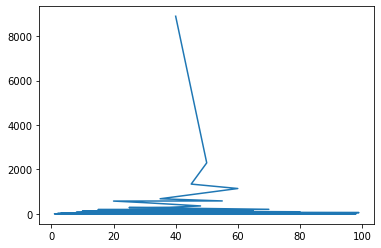

In [10]:
X["hours-per-week"].value_counts().plot()

In [11]:
median_hours = X["hours-per-week"].median() # '1' if the client works over 40 hours per week

X["hours-per-week"] = (X["hours-per-week"] == median_hours).astype(int)
X["hours-per-week"]

42436    0
8768     0
10244    0
35241    0
8319     0
        ..
20395    1
7042     1
27224    0
42516    1
35091    0
Name: hours-per-week, Length: 20000, dtype: int64

### Train-test-split, to prepare for 3 graphs representing data

In [12]:
model_task = "classification"
preprocessing_cat_features = "label_encoding"

X_train, X_valid, X_train_valid, X_test, Y_train, Y_valid, Y_train_valid, Y_test = train_valid_test_split(
    X=X,
    Y=Y, 
    model_task=model_task,
    preprocessing_cat_features=preprocessing_cat_features)

## Reshape (by interpreting) data to a graph

From this dataset (where we introduced selectively a "sexist" effect against women), let's see how we could swith from the tabular data to a graph representation.

The point is that our features X all seem to be attributes of the clients, though we should find a way of representing their interactions between clients 

X = {race, age, sex, final weight (depends on age, sex, hispanic origin, race), education, education number, marital status, relationship, occupation, hours per week, workclass, race, sex, capital gain, capital loss, native country} 

**Nodes** 
Bank clients (by ID)

**Edges** 
Here, we should find one or several ways of connecting the clients

Should be occupation → if changes of occupation (or similar client with new occupation), which impact on the revenue? // change of football team => impact on the football rate 
(pers) actionable => predict revenue when switches to a new job??
→ may be: “hours per week” <=> inspect the change of revenue if switches to greater hours per week?

**Node Features** 
Attributs of the nodes, i.e. characteristics of the clients (here, hard to separate from what "connects" them...) 

Race, age, sex, final weight (depends on age, sex, hispanic origin, race), education, education number, marital status, relationship, hours per week, workclass, race, sex, capital gain, capital loss, native country 

**Label (here at a node-level?)** 
Income (Y = income > $50 000)

In [13]:
# compute edge by hands: create our own edge combination, to predict the income - with directed paths
# first edge joins "occupation" -> "hours-per-week"
# second edge joins "sex" -> "education"

edges_train = add_new_edge(data=X_train, previous_edge=None, list_col_names=["occupation", "hours-per-week"])
#edges_train = add_new_edge(data=X_train, previous_edge=edges_train, list_col_names=["sex","education"])

edges_valid = add_new_edge(data=X_valid, previous_edge=None, list_col_names=["occupation", "hours-per-week"])
#edges_valid = add_new_edge(data=X_valid, previous_edge=edges_valid, list_col_names=["sex","education"])

edges_test = add_new_edge(data=X_test, previous_edge=None, list_col_names=["occupation", "hours-per-week"])
#edges_test = add_new_edge(data=X_test, previous_edge=edges_test, list_col_names=["sex","education"])

# specify the feature(s) used to connect the clients in couples, i.e. to build the edge of the data graph

list_col_names = ["occupation", "hours-per-week"]#, "sex","education"]

data_train = table_to_graph(X=X_train, Y=Y_train, list_col_names=list_col_names, edges=edges_train)
data_valid = table_to_graph(X=X_valid, Y=Y_valid, list_col_names=list_col_names, edges=edges_valid)
data_test = table_to_graph(X=X_test, Y=Y_test, list_col_names=list_col_names, edges=edges_test)

In [14]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [16]:
data_train

Data(x=[14450, 13], edge_index=[2, 10808118], y=[14450], num_classes=2, is_directed=True)

In [17]:
data_valid

Data(x=[2550, 13], edge_index=[2, 334831], y=[2550], num_classes=2, is_directed=True)

In [18]:
data_test

Data(x=[3000, 13], edge_index=[2, 261879], y=[3000], num_classes=2, is_directed=True)

# Train a basic Graph Neural Network on the graph-shaped data

## Build a basic convolutional GNN with torch

In [19]:
# here intervenes the quick "introduction by example" of GCN by torch
# in 'https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html'

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [20]:
batch_nb = 200

t_basic_1 = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(data=data_train).to(device)
data_train = data_train.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.double()

model.train()
for epoch in range(batch_nb): 
    # better with 200 batches (with only feature "occupation" as edge, 70% accuracy vs 50% accuracy with 50 batches)
    optimizer.zero_grad()
    out = model(data_train)
    loss = F.nll_loss(out, data_train.y)
    loss.backward()
    optimizer.step()

t_basic_2 = time.time()

print(f"Training of the basic GCN on Census with {batch_nb} batches took {(t_basic_2 - t_basic_1)/60} mn")

Training of the basic GCN on Census with 200 batches took 18.026376167933147 mn


Finally, we can evaluate our model on the validation nodes. Obviously, linking the clients only through the job provides less than 70% of accuracy even on the train set. Therefore, we need to seek for other ways...

By creating an edge only with the combination of sex and education, we observe an accuracy of 61% on train that does not fall down on valid (65%). Moreover, **when the graph is directed (sex -> education), the accuracy seems to increase** without falling down valid performance: + 11% on train (76%), +2% on valid (67%), and 70% on test.  

Thanks to the training of the GCN with 200 batches, which however took 20 mn for 15_000 rows and 2 classes (and we shall admit, edge_index=[2, 10813909])

**Other observations (tests of combinations of features as edges)**

Having created our own edge index combining (sex&education) and (occupation), the training took 7 mn more (27 mn) but the performance did not improve (61% on train set...)

Adding the combination (occupation -> hours-per-week) to (sex -> education) does not improve the performances, but it decreases it (60 +-2 % on train and valid). Maybe because (i) it complexifies too much the network (ii) the model or (iii) the model's hyperparameters (batch, layers...) is too simple to catch these relations (iii) the models? 

**Constitution of couples graph data - graph networks to be tested, with input intervention changes...**

In [21]:
pred_train = model(data_train).argmax(dim=1)
nb_indivs_train = data_train.x.shape[0]

model.eval()

correct_train = (pred_train == data_train.y).sum()
acc = int(correct_train) / nb_indivs_train
print(f'Accuracy on train data: {acc:.4f}')

Accuracy on train data: 0.5994


In [22]:
pred_valid = model(data_valid).argmax(dim=1)
nb_indivs_valid = data_valid.x.shape[0]

model.eval()

correct_valid = (pred_valid == data_valid.y).sum()
acc = int(correct_valid) / nb_indivs_valid
print(f'Accuracy on valid data: {acc:.4f}')

Accuracy on valid data: 0.6784


Let's inspect the model on test data, to assess if the stability of performance is not due to coincidence:

In [23]:
pred_test = model(data_test).argmax(dim=1)
nb_indivs_test = data_test.x.shape[0]

model.eval()

correct_test = (pred_test == data_test.y).sum()
acc = int(correct_test) / nb_indivs_test
print(f'Accuracy on test data: {acc:.4f}')

Accuracy on test data: 0.6403


# Visual Representation of the Graph
Here, we will seek for a visual representation of the (directed acyclic?) graph. The goal is to check if it corresponds to the users' intuition - at least regarding the "non sense" causal paths. 

Here, the edges have been built with the directed path **sex -> education** (recall that the link [potentially] exists, because we voluntarily biased the data to be "sexist" regarding the distribution of incomes). Hence, the non-sense we don't want to find is an impact of education on sex. 

In [24]:
import networkx as nx

from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

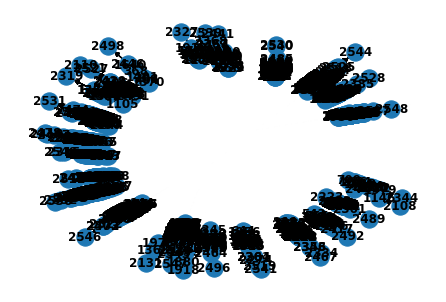

In [25]:
network_valid = to_networkx(data=data_valid)

# subax1 = plt.subplot(121)

# graph 
nx.draw(network_valid, with_labels=True, font_weight='bold')

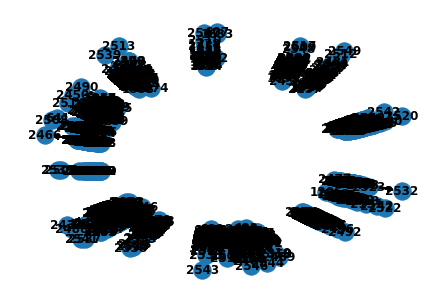

In [28]:
list_col_names = ["occupation", "hours-per-week"]#, "sex","education"]

data_job_valid = table_to_graph(X=X_valid, Y=Y_valid, list_col_names=list_col_names, edges=edges_valid)

network_job_valid = to_networkx(data=data_job_valid)
nx.draw(network_job_valid, with_labels=True, font_weight='bold')

In [29]:
data_valid.x.shape[0]

2550

In [82]:
# create a representation of the edge ("sex -> education") 
# with only 2 values of education and 20 individuals (min, max)

X_valid.reset_index(drop=True, inplace=True)
Y_valid.reset_index(drop=True, inplace=True)

df_education_max = X_valid.loc[X_valid["education"]==X_valid["education"].max()].iloc[:10]
#df_education_min = X_valid.loc[X_valid["education"]==X_valid["education"].min()].iloc[:10]

X_education_extreme = df_education_max#.append(df_education_min).sort_index()
Y_education_extreme = Y_valid.iloc[X_education_extreme.index]

Plotting the graph with 10 individuals took 3.9244640469551086 mn


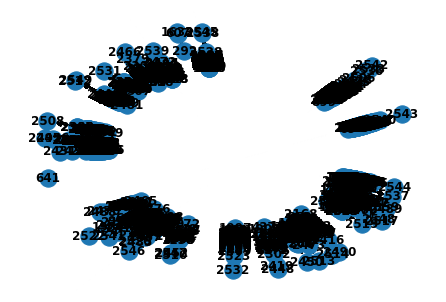

In [83]:
# here, gain a representation with only 10 individuals 

t_graph_0 = time.time()

list_col_names = ["sex", "education"]

edges_sex_valid = add_new_edge(data=X_education_extreme, previous_edge=None, list_col_names=list_col_names)

data_sex_valid = table_to_graph(X=X_education_extreme, Y=Y_education_extreme, list_col_names=list_col_names, 
                                edges=edges_sex_valid)

network_job_valid = to_networkx(data=data_job_valid)
nx.draw(network_job_valid, with_labels=True, font_weight='bold')

t_graph_1 = time.time()

print(f"Plotting the graph with {data_sex_valid.x.shape[0]} individuals took {(t_graph_1 - t_graph_0)/60} mn")

Plotting the graph with 10 individuals took 5.548641590277354 mn


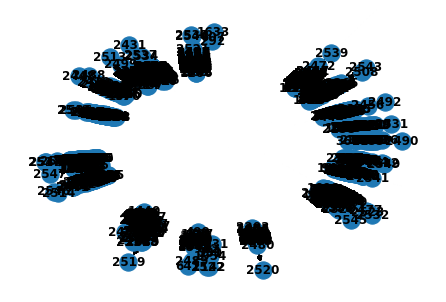

In [85]:
# here, gain a representation with only 10 individuals (and only 'sex' as edge)

t_graph_0 = time.time()

list_col_names = ["sex"]

edges_sex_valid = add_new_edge(data=X_education_extreme, previous_edge=None, list_col_names=list_col_names)

data_sex_valid = table_to_graph(X=X_education_extreme, Y=Y_education_extreme, list_col_names=list_col_names, 
                                edges=edges_sex_valid)

network_job_valid = to_networkx(data=data_job_valid)
nx.draw(network_job_valid, with_labels=True, font_weight='bold')

t_graph_1 = time.time()

print(f"Plotting the graph with {data_sex_valid.x.shape[0]} individuals took {(t_graph_1 - t_graph_0)/60} mn")

Plotting the graph with 10 individuals took 3.5399219075838726 mn


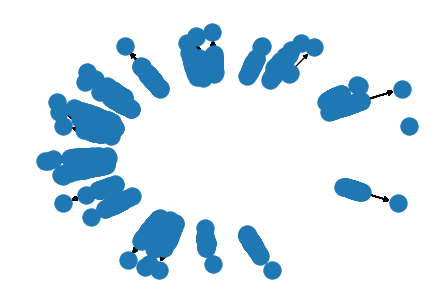

In [86]:
# here, gain a representation with only 10 individuals (and only 'sex' as edge)

t_graph_0 = time.time()

list_col_names = ["sex"]

edges_sex_valid = add_new_edge(data=X_education_extreme, previous_edge=None, list_col_names=list_col_names)

data_sex_valid = table_to_graph(X=X_education_extreme, Y=Y_education_extreme, list_col_names=list_col_names, 
                                edges=edges_sex_valid)

network_job_valid = to_networkx(data=data_job_valid)
nx.draw(network_job_valid)

t_graph_1 = time.time()

print(f"Plotting the graph with {data_sex_valid.x.shape[0]} individuals took {(t_graph_1 - t_graph_0)/60} mn")

Plotting the graph with 10 individuals took 3.973481818040212 mn


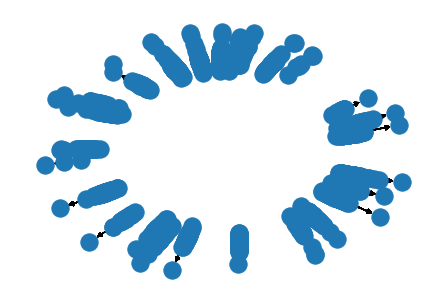

In [91]:
# here, gain a representation with only 10 individuals (and only 'sex' as edge)

t_graph_0 = time.time()

list_col_names = ['capital-gain', 'capital-loss',
       'hours-per-week', 'workclass', 'education', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'native-country',
       'clients_id'] # to take only the likely 'relevant' features 'age', 'fnlwgt', 'education-num' as node

edges_sex_valid = add_new_edge(data=X_education_extreme, previous_edge=None, list_col_names=['sex'])

data_sex_valid = table_to_graph(X=X_education_extreme, Y=Y_education_extreme, list_col_names=list_col_names, 
                                edges=edges_sex_valid)

network_job_valid = to_networkx(data=data_job_valid)
nx.draw(network_job_valid)

t_graph_1 = time.time()

print(f"Plotting the graph with {data_sex_valid.x.shape[0]} individuals took {(t_graph_1 - t_graph_0)/60} mn")

Plotting the graph with 10 individuals took 4.51864767074585 mn


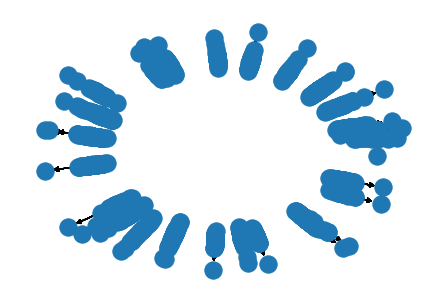

In [92]:
# here, gain a representation with only 10 individuals (and only 'sex' as edge)

t_graph_0 = time.time()

list_col_names = ['age', 'fnlwgt', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass', 'education', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'native-country',
       'clients_id'] # to take only the likely 'relevant' feature 'education-num' as node

edges_sex_valid = add_new_edge(data=X_education_extreme, previous_edge=None, list_col_names=['sex'])

data_sex_valid = table_to_graph(X=X_education_extreme, Y=Y_education_extreme, list_col_names=list_col_names, 
                                edges=edges_sex_valid)

network_job_valid = to_networkx(data=data_job_valid)
nx.draw(network_job_valid)

t_graph_1 = time.time()

print(f"Plotting the graph with {data_sex_valid.x.shape[0]} individuals took {(t_graph_1 - t_graph_0)/60} mn")

Obviously, we have no clear intuition of what these links do correspond with... By individual, path from the sex to the income? But there are more groups than individuals here selected (10)...

## Constitute a graph - Try to connect the features 

Here, we proceed in 2 steps (back and forth)

1. **Detect the relations**
We use the partial dependance plots to inspect the correlations (pers) sufficient? Input intervention changes?

1. **Select the causal direction**
Based on the user's experience and expertise (e.g. sex -> education, because the contrary would be logically and temporally impossible)

At a first sight, look at correlated features (!) may be some hidden correlations => experience is still required at this stage:

In [ ]:
# reconstitute the dataset to check the correlations

data_train_valid = X_train_valid.copy()
data_train_valid['target'] = Y_train_valid
data_train_valid

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(data_train_valid.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

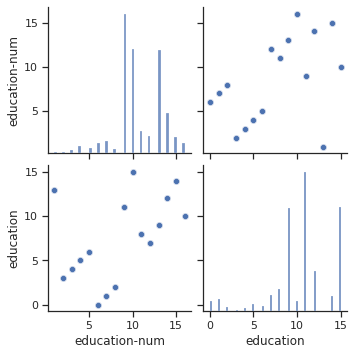

In [111]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)    
g = sns.pairplot(X_train_valid.filter(items=['education-num','education']))
plt.show()

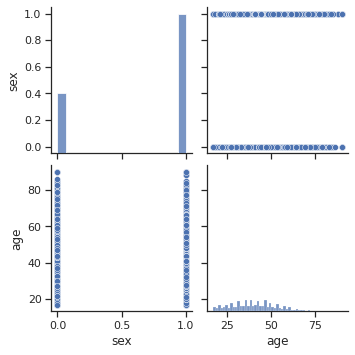

In [112]:
g = sns.pairplot(X_train_valid.filter(items=['sex','age']))
plt.show()

TypeError: GCN(
  (conv1): GCNConv(13, 16)
  (conv2): GCNConv(16, 2)
) is not an estimator instance.

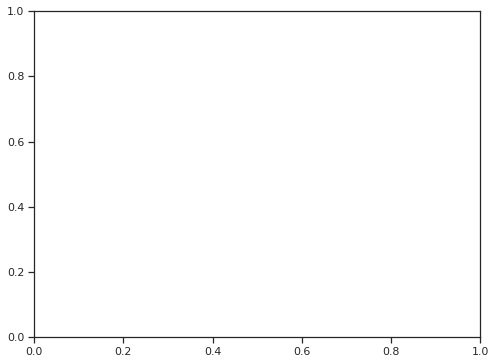

In [115]:
from sklearn.inspection import PartialDependenceDisplay

# detect the relations: show the changes in predictions for the combinations of 2 features
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('sex', 'education')]
# Similar to previous PDP plot except we use tuple of features instead of single feature
disp4 = PartialDependenceDisplay.from_estimator(model, X_valid, f_names, ax=ax)
plt.show()